In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
%matplotlib inline

### Dados
- são carregados os dados pre-procesados no notebook: Data pre-processing

In [401]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [47]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [48]:
X_train = datos.loc[rg]
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [52]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [402]:
datos = ((datos - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
datos.shape

(4205, 9)

In [ ]:
datos = datos.drop(rg)
datos.shape

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [306]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [307]:
noise_input = 50
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  50


In [308]:
G.summary()

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_210 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_211 (Dense)            (None, 150)               7650      
_________________________________________________________________
dense_212 (Dense)            (None, 9)                 1359      
_________________________________________________________________
reshape_38 (Reshape)         (None, 9)                 0         
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
_________________________________________________________________


In [309]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimensão dos dados de entrada:", noise.shape)
data_sint = G.predict(noise)
print("Dimensão dos dados generados:", data_sint.shape)

Dimensão dos dados de entrada: (20, 50)
Dimensão dos dados generados: (20, 9)


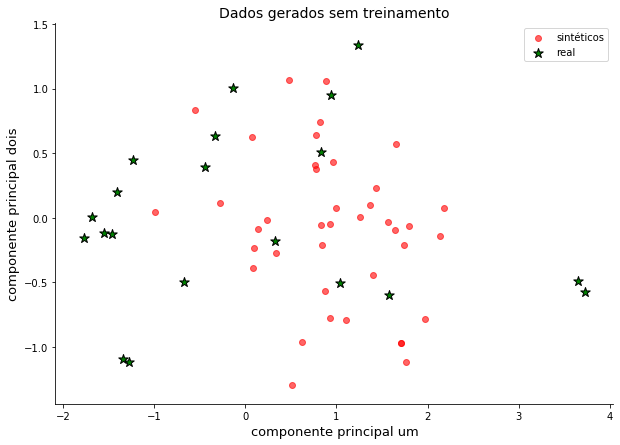

In [310]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0]*2, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.6)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [311]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [312]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

In [313]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [314]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [315]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    fscore = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_real = X_train.loc[np.random.choice(X_train.index.values, size=20, replace=False)]
        X_fake = G.predict(np.random.normal(0, 1, (20, noise_input)))
        X_test = np.concatenate((X_real, X_fake))
        y_test = np.concatenate((np.ones((20,1)), np.ones((20,1))))
        y_predict = D.predict_classes(X_test)
        #f1_lag = f1_score(y_test, y_predict)
        fscore.append(np.mean((y_predict - y_test)**2))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, fscore

In [316]:
noise_input = 50
#Gerador
#optimizerG = SGD(lr=0.00011, momentum=0.92, decay=0.0001/2000)
optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
#optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/2000)
optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_97 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_98 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [317]:
ep = 2000
g_loss, d_loss, fscore = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/2000] [Discriminator::d_loss: 0.794864],[Generator::loss: 0.691588], 8.183717[sec]
epoch:[2/2000] [Discriminator::d_loss: 0.775207],[Generator::loss: 0.729287], 0.017556[sec]
epoch:[3/2000] [Discriminator::d_loss: 0.785114],[Generator::loss: 0.755775], 0.017403[sec]
epoch:[4/2000] [Discriminator::d_loss: 0.774129],[Generator::loss: 0.716406], 0.016865[sec]
epoch:[5/2000] [Discriminator::d_loss: 0.830229],[Generator::loss: 0.698510], 0.017623[sec]
epoch:[6/2000] [Discriminator::d_loss: 0.811290],[Generator::loss: 0.693043], 0.017050[sec]
epoch:[7/2000] [Discriminator::d_loss: 0.812536],[Generator::loss: 0.704290], 0.016752[sec]
epoch:[8/2000] [Discriminator::d_loss: 0.772119],[Generator::loss: 0.785943], 0.016795[sec]
epoch:[9/2000] [Discriminator::d_loss: 0.745044],[Generator::loss: 0.748973], 0.016823[sec]
epoch:[10/2000] [Discriminator::d_loss: 0.823037],[Generator::loss: 0.672738], 0.017462[sec]
epoch:[11/2000] [Discriminator::d_loss: 0.788529],[Generator::loss: 0.690764], 

epoch:[97/2000] [Discriminator::d_loss: 0.632965],[Generator::loss: 0.741027], 0.019926[sec]
epoch:[98/2000] [Discriminator::d_loss: 0.641736],[Generator::loss: 0.693978], 0.020544[sec]
epoch:[99/2000] [Discriminator::d_loss: 0.606665],[Generator::loss: 0.749867], 0.018287[sec]
epoch:[100/2000] [Discriminator::d_loss: 0.636164],[Generator::loss: 0.734491], 0.018465[sec]
epoch:[101/2000] [Discriminator::d_loss: 0.633222],[Generator::loss: 0.745828], 0.016876[sec]
epoch:[102/2000] [Discriminator::d_loss: 0.691853],[Generator::loss: 0.713653], 0.016613[sec]
epoch:[103/2000] [Discriminator::d_loss: 0.639312],[Generator::loss: 0.743115], 0.016764[sec]
epoch:[104/2000] [Discriminator::d_loss: 0.671034],[Generator::loss: 0.736052], 0.016622[sec]
epoch:[105/2000] [Discriminator::d_loss: 0.633706],[Generator::loss: 0.727531], 0.016673[sec]
epoch:[106/2000] [Discriminator::d_loss: 0.641983],[Generator::loss: 0.790965], 0.017567[sec]
epoch:[107/2000] [Discriminator::d_loss: 0.631641],[Generator::

epoch:[192/2000] [Discriminator::d_loss: 0.594174],[Generator::loss: 0.818625], 0.021590[sec]
epoch:[193/2000] [Discriminator::d_loss: 0.565048],[Generator::loss: 0.787904], 0.020401[sec]
epoch:[194/2000] [Discriminator::d_loss: 0.585043],[Generator::loss: 0.818936], 0.016936[sec]
epoch:[195/2000] [Discriminator::d_loss: 0.644152],[Generator::loss: 0.775491], 0.018158[sec]
epoch:[196/2000] [Discriminator::d_loss: 0.571624],[Generator::loss: 0.750056], 0.016606[sec]
epoch:[197/2000] [Discriminator::d_loss: 0.573391],[Generator::loss: 0.788821], 0.016932[sec]
epoch:[198/2000] [Discriminator::d_loss: 0.622398],[Generator::loss: 0.840357], 0.016469[sec]
epoch:[199/2000] [Discriminator::d_loss: 0.593045],[Generator::loss: 0.829797], 0.016794[sec]
epoch:[200/2000] [Discriminator::d_loss: 0.555175],[Generator::loss: 0.798907], 0.016716[sec]
epoch:[201/2000] [Discriminator::d_loss: 0.614071],[Generator::loss: 0.867201], 0.017343[sec]
epoch:[202/2000] [Discriminator::d_loss: 0.646356],[Generato

epoch:[288/2000] [Discriminator::d_loss: 0.570017],[Generator::loss: 0.864429], 0.021273[sec]
epoch:[289/2000] [Discriminator::d_loss: 0.618465],[Generator::loss: 0.835014], 0.017713[sec]
epoch:[290/2000] [Discriminator::d_loss: 0.583073],[Generator::loss: 0.846342], 0.017432[sec]
epoch:[291/2000] [Discriminator::d_loss: 0.563822],[Generator::loss: 0.856467], 0.017887[sec]
epoch:[292/2000] [Discriminator::d_loss: 0.591114],[Generator::loss: 0.824784], 0.016904[sec]
epoch:[293/2000] [Discriminator::d_loss: 0.601207],[Generator::loss: 0.854835], 0.016906[sec]
epoch:[294/2000] [Discriminator::d_loss: 0.606892],[Generator::loss: 0.849288], 0.016934[sec]
epoch:[295/2000] [Discriminator::d_loss: 0.552759],[Generator::loss: 0.868481], 0.016709[sec]
epoch:[296/2000] [Discriminator::d_loss: 0.534024],[Generator::loss: 0.906469], 0.017107[sec]
epoch:[297/2000] [Discriminator::d_loss: 0.581052],[Generator::loss: 0.944119], 0.017518[sec]
epoch:[298/2000] [Discriminator::d_loss: 0.595177],[Generato

epoch:[384/2000] [Discriminator::d_loss: 0.517661],[Generator::loss: 0.847712], 0.017868[sec]
epoch:[385/2000] [Discriminator::d_loss: 0.581253],[Generator::loss: 0.882397], 0.019312[sec]
epoch:[386/2000] [Discriminator::d_loss: 0.551225],[Generator::loss: 0.818048], 0.017073[sec]
epoch:[387/2000] [Discriminator::d_loss: 0.587041],[Generator::loss: 0.834007], 0.017767[sec]
epoch:[388/2000] [Discriminator::d_loss: 0.523714],[Generator::loss: 0.940969], 0.017476[sec]
epoch:[389/2000] [Discriminator::d_loss: 0.554613],[Generator::loss: 0.873929], 0.016960[sec]
epoch:[390/2000] [Discriminator::d_loss: 0.594134],[Generator::loss: 0.878574], 0.016877[sec]
epoch:[391/2000] [Discriminator::d_loss: 0.529444],[Generator::loss: 0.863437], 0.016756[sec]
epoch:[392/2000] [Discriminator::d_loss: 0.562767],[Generator::loss: 0.916299], 0.016509[sec]
epoch:[393/2000] [Discriminator::d_loss: 0.521192],[Generator::loss: 0.909338], 0.017772[sec]
epoch:[394/2000] [Discriminator::d_loss: 0.525590],[Generato

epoch:[480/2000] [Discriminator::d_loss: 0.539211],[Generator::loss: 0.967824], 0.017966[sec]
epoch:[481/2000] [Discriminator::d_loss: 0.596826],[Generator::loss: 0.982608], 0.022543[sec]
epoch:[482/2000] [Discriminator::d_loss: 0.549308],[Generator::loss: 0.886759], 0.018506[sec]
epoch:[483/2000] [Discriminator::d_loss: 0.574889],[Generator::loss: 0.821869], 0.017826[sec]
epoch:[484/2000] [Discriminator::d_loss: 0.516232],[Generator::loss: 0.912636], 0.016893[sec]
epoch:[485/2000] [Discriminator::d_loss: 0.539237],[Generator::loss: 0.879473], 0.017022[sec]
epoch:[486/2000] [Discriminator::d_loss: 0.491354],[Generator::loss: 0.893751], 0.017744[sec]
epoch:[487/2000] [Discriminator::d_loss: 0.557918],[Generator::loss: 0.911680], 0.016745[sec]
epoch:[488/2000] [Discriminator::d_loss: 0.551932],[Generator::loss: 0.922523], 0.018153[sec]
epoch:[489/2000] [Discriminator::d_loss: 0.510413],[Generator::loss: 0.881789], 0.017282[sec]
epoch:[490/2000] [Discriminator::d_loss: 0.593791],[Generato

epoch:[576/2000] [Discriminator::d_loss: 0.526006],[Generator::loss: 1.024242], 0.019109[sec]
epoch:[577/2000] [Discriminator::d_loss: 0.579682],[Generator::loss: 0.948659], 0.018535[sec]
epoch:[578/2000] [Discriminator::d_loss: 0.516067],[Generator::loss: 1.050664], 0.017243[sec]
epoch:[579/2000] [Discriminator::d_loss: 0.526242],[Generator::loss: 1.060169], 0.017798[sec]
epoch:[580/2000] [Discriminator::d_loss: 0.511698],[Generator::loss: 0.967856], 0.017135[sec]
epoch:[581/2000] [Discriminator::d_loss: 0.531803],[Generator::loss: 0.870637], 0.016523[sec]
epoch:[582/2000] [Discriminator::d_loss: 0.543508],[Generator::loss: 0.985795], 0.016660[sec]
epoch:[583/2000] [Discriminator::d_loss: 0.555968],[Generator::loss: 0.999788], 0.016718[sec]
epoch:[584/2000] [Discriminator::d_loss: 0.521215],[Generator::loss: 1.013183], 0.017245[sec]
epoch:[585/2000] [Discriminator::d_loss: 0.540045],[Generator::loss: 0.891031], 0.016950[sec]
epoch:[586/2000] [Discriminator::d_loss: 0.531133],[Generato

epoch:[672/2000] [Discriminator::d_loss: 0.510004],[Generator::loss: 0.964728], 0.018384[sec]
epoch:[673/2000] [Discriminator::d_loss: 0.502461],[Generator::loss: 1.055805], 0.019254[sec]
epoch:[674/2000] [Discriminator::d_loss: 0.540519],[Generator::loss: 0.896627], 0.017637[sec]
epoch:[675/2000] [Discriminator::d_loss: 0.505730],[Generator::loss: 0.957508], 0.019003[sec]
epoch:[676/2000] [Discriminator::d_loss: 0.568229],[Generator::loss: 0.977559], 0.016970[sec]
epoch:[677/2000] [Discriminator::d_loss: 0.611076],[Generator::loss: 0.967249], 0.016988[sec]
epoch:[678/2000] [Discriminator::d_loss: 0.522017],[Generator::loss: 0.935257], 0.016673[sec]
epoch:[679/2000] [Discriminator::d_loss: 0.509525],[Generator::loss: 0.973443], 0.016780[sec]
epoch:[680/2000] [Discriminator::d_loss: 0.519905],[Generator::loss: 1.052140], 0.017788[sec]
epoch:[681/2000] [Discriminator::d_loss: 0.529285],[Generator::loss: 0.966948], 0.018270[sec]
epoch:[682/2000] [Discriminator::d_loss: 0.539122],[Generato

epoch:[768/2000] [Discriminator::d_loss: 0.564165],[Generator::loss: 1.097860], 0.023136[sec]
epoch:[769/2000] [Discriminator::d_loss: 0.536278],[Generator::loss: 1.054495], 0.017570[sec]
epoch:[770/2000] [Discriminator::d_loss: 0.517124],[Generator::loss: 0.944099], 0.018324[sec]
epoch:[771/2000] [Discriminator::d_loss: 0.560103],[Generator::loss: 0.903955], 0.017309[sec]
epoch:[772/2000] [Discriminator::d_loss: 0.527851],[Generator::loss: 0.891967], 0.017357[sec]
epoch:[773/2000] [Discriminator::d_loss: 0.580123],[Generator::loss: 1.025861], 0.016918[sec]
epoch:[774/2000] [Discriminator::d_loss: 0.570924],[Generator::loss: 1.021187], 0.016689[sec]
epoch:[775/2000] [Discriminator::d_loss: 0.545033],[Generator::loss: 1.103396], 0.016533[sec]
epoch:[776/2000] [Discriminator::d_loss: 0.556712],[Generator::loss: 1.035044], 0.017954[sec]
epoch:[777/2000] [Discriminator::d_loss: 0.562424],[Generator::loss: 0.848393], 0.018002[sec]
epoch:[778/2000] [Discriminator::d_loss: 0.615085],[Generato

epoch:[864/2000] [Discriminator::d_loss: 0.548667],[Generator::loss: 1.011312], 0.023148[sec]
epoch:[865/2000] [Discriminator::d_loss: 0.550938],[Generator::loss: 0.975556], 0.017666[sec]
epoch:[866/2000] [Discriminator::d_loss: 0.638974],[Generator::loss: 0.985934], 0.017793[sec]
epoch:[867/2000] [Discriminator::d_loss: 0.575459],[Generator::loss: 0.902033], 0.016944[sec]
epoch:[868/2000] [Discriminator::d_loss: 0.600913],[Generator::loss: 0.896755], 0.016938[sec]
epoch:[869/2000] [Discriminator::d_loss: 0.532205],[Generator::loss: 0.732470], 0.016897[sec]
epoch:[870/2000] [Discriminator::d_loss: 0.482815],[Generator::loss: 0.863195], 0.016632[sec]
epoch:[871/2000] [Discriminator::d_loss: 0.585532],[Generator::loss: 0.997661], 0.017735[sec]
epoch:[872/2000] [Discriminator::d_loss: 0.502825],[Generator::loss: 0.943357], 0.017732[sec]
epoch:[873/2000] [Discriminator::d_loss: 0.629519],[Generator::loss: 0.937780], 0.016876[sec]
epoch:[874/2000] [Discriminator::d_loss: 0.599668],[Generato

epoch:[960/2000] [Discriminator::d_loss: 0.591772],[Generator::loss: 1.079278], 0.022741[sec]
epoch:[961/2000] [Discriminator::d_loss: 0.613581],[Generator::loss: 0.985374], 0.019547[sec]
epoch:[962/2000] [Discriminator::d_loss: 0.611266],[Generator::loss: 0.871137], 0.017476[sec]
epoch:[963/2000] [Discriminator::d_loss: 0.598033],[Generator::loss: 0.883054], 0.016668[sec]
epoch:[964/2000] [Discriminator::d_loss: 0.631534],[Generator::loss: 0.905130], 0.016906[sec]
epoch:[965/2000] [Discriminator::d_loss: 0.608961],[Generator::loss: 0.896666], 0.017246[sec]
epoch:[966/2000] [Discriminator::d_loss: 0.597702],[Generator::loss: 0.851680], 0.016877[sec]
epoch:[967/2000] [Discriminator::d_loss: 0.661974],[Generator::loss: 0.805585], 0.018556[sec]
epoch:[968/2000] [Discriminator::d_loss: 0.570342],[Generator::loss: 0.865008], 0.017004[sec]
epoch:[969/2000] [Discriminator::d_loss: 0.554118],[Generator::loss: 0.853435], 0.017227[sec]
epoch:[970/2000] [Discriminator::d_loss: 0.619636],[Generato

epoch:[1056/2000] [Discriminator::d_loss: 0.576197],[Generator::loss: 0.960476], 0.018528[sec]
epoch:[1057/2000] [Discriminator::d_loss: 0.680341],[Generator::loss: 0.781288], 0.020098[sec]
epoch:[1058/2000] [Discriminator::d_loss: 0.608286],[Generator::loss: 0.742840], 0.017746[sec]
epoch:[1059/2000] [Discriminator::d_loss: 0.739232],[Generator::loss: 0.829942], 0.017082[sec]
epoch:[1060/2000] [Discriminator::d_loss: 0.626803],[Generator::loss: 0.926327], 0.016756[sec]
epoch:[1061/2000] [Discriminator::d_loss: 0.643025],[Generator::loss: 0.865289], 0.016964[sec]
epoch:[1062/2000] [Discriminator::d_loss: 0.646089],[Generator::loss: 0.882849], 0.016960[sec]
epoch:[1063/2000] [Discriminator::d_loss: 0.683659],[Generator::loss: 0.803946], 0.017162[sec]
epoch:[1064/2000] [Discriminator::d_loss: 0.673307],[Generator::loss: 0.992983], 0.017264[sec]
epoch:[1065/2000] [Discriminator::d_loss: 0.680109],[Generator::loss: 0.779147], 0.017181[sec]
epoch:[1066/2000] [Discriminator::d_loss: 0.594725

epoch:[1152/2000] [Discriminator::d_loss: 0.611226],[Generator::loss: 0.773470], 0.019790[sec]
epoch:[1153/2000] [Discriminator::d_loss: 0.698340],[Generator::loss: 0.814856], 0.018497[sec]
epoch:[1154/2000] [Discriminator::d_loss: 0.628123],[Generator::loss: 0.904799], 0.017601[sec]
epoch:[1155/2000] [Discriminator::d_loss: 0.680572],[Generator::loss: 0.825917], 0.017025[sec]
epoch:[1156/2000] [Discriminator::d_loss: 0.627257],[Generator::loss: 0.707130], 0.016567[sec]
epoch:[1157/2000] [Discriminator::d_loss: 0.668781],[Generator::loss: 0.933206], 0.016904[sec]
epoch:[1158/2000] [Discriminator::d_loss: 0.665215],[Generator::loss: 0.816703], 0.016657[sec]
epoch:[1159/2000] [Discriminator::d_loss: 0.582729],[Generator::loss: 0.949792], 0.017755[sec]
epoch:[1160/2000] [Discriminator::d_loss: 0.740526],[Generator::loss: 0.855806], 0.018122[sec]
epoch:[1161/2000] [Discriminator::d_loss: 0.711370],[Generator::loss: 0.942918], 0.016649[sec]
epoch:[1162/2000] [Discriminator::d_loss: 0.672910

epoch:[1248/2000] [Discriminator::d_loss: 0.673115],[Generator::loss: 0.874696], 0.023333[sec]
epoch:[1249/2000] [Discriminator::d_loss: 0.672365],[Generator::loss: 0.850197], 0.018376[sec]
epoch:[1250/2000] [Discriminator::d_loss: 0.630825],[Generator::loss: 0.798140], 0.016917[sec]
epoch:[1251/2000] [Discriminator::d_loss: 0.651111],[Generator::loss: 0.779847], 0.017437[sec]
epoch:[1252/2000] [Discriminator::d_loss: 0.673786],[Generator::loss: 0.824917], 0.017607[sec]
epoch:[1253/2000] [Discriminator::d_loss: 0.655149],[Generator::loss: 0.877578], 0.016951[sec]
epoch:[1254/2000] [Discriminator::d_loss: 0.627121],[Generator::loss: 0.855496], 0.017782[sec]
epoch:[1255/2000] [Discriminator::d_loss: 0.634986],[Generator::loss: 0.787844], 0.018064[sec]
epoch:[1256/2000] [Discriminator::d_loss: 0.688926],[Generator::loss: 0.817334], 0.016762[sec]
epoch:[1257/2000] [Discriminator::d_loss: 0.638272],[Generator::loss: 0.922711], 0.016654[sec]
epoch:[1258/2000] [Discriminator::d_loss: 0.668598

epoch:[1344/2000] [Discriminator::d_loss: 0.661918],[Generator::loss: 0.758099], 0.023395[sec]
epoch:[1345/2000] [Discriminator::d_loss: 0.726140],[Generator::loss: 0.841406], 0.017508[sec]
epoch:[1346/2000] [Discriminator::d_loss: 0.674962],[Generator::loss: 0.854794], 0.017128[sec]
epoch:[1347/2000] [Discriminator::d_loss: 0.642671],[Generator::loss: 0.842664], 0.016675[sec]
epoch:[1348/2000] [Discriminator::d_loss: 0.660227],[Generator::loss: 0.809714], 0.016705[sec]
epoch:[1349/2000] [Discriminator::d_loss: 0.715164],[Generator::loss: 0.762303], 0.016808[sec]
epoch:[1350/2000] [Discriminator::d_loss: 0.648521],[Generator::loss: 0.653653], 0.017792[sec]
epoch:[1351/2000] [Discriminator::d_loss: 0.684355],[Generator::loss: 0.805357], 0.019010[sec]
epoch:[1352/2000] [Discriminator::d_loss: 0.679984],[Generator::loss: 0.766430], 0.017436[sec]
epoch:[1353/2000] [Discriminator::d_loss: 0.712153],[Generator::loss: 0.899107], 0.017629[sec]
epoch:[1354/2000] [Discriminator::d_loss: 0.642922

epoch:[1440/2000] [Discriminator::d_loss: 0.681481],[Generator::loss: 0.802415], 0.021860[sec]
epoch:[1441/2000] [Discriminator::d_loss: 0.757414],[Generator::loss: 0.794392], 0.018846[sec]
epoch:[1442/2000] [Discriminator::d_loss: 0.703826],[Generator::loss: 0.713958], 0.017390[sec]
epoch:[1443/2000] [Discriminator::d_loss: 0.695845],[Generator::loss: 0.795206], 0.017378[sec]
epoch:[1444/2000] [Discriminator::d_loss: 0.675241],[Generator::loss: 0.709212], 0.017384[sec]
epoch:[1445/2000] [Discriminator::d_loss: 0.698225],[Generator::loss: 0.814626], 0.019767[sec]
epoch:[1446/2000] [Discriminator::d_loss: 0.668290],[Generator::loss: 0.966677], 0.016934[sec]
epoch:[1447/2000] [Discriminator::d_loss: 0.673091],[Generator::loss: 0.735123], 0.017435[sec]
epoch:[1448/2000] [Discriminator::d_loss: 0.664618],[Generator::loss: 0.764583], 0.016834[sec]
epoch:[1449/2000] [Discriminator::d_loss: 0.693288],[Generator::loss: 0.816921], 0.017394[sec]
epoch:[1450/2000] [Discriminator::d_loss: 0.663976

epoch:[1536/2000] [Discriminator::d_loss: 0.698026],[Generator::loss: 0.849439], 0.018968[sec]
epoch:[1537/2000] [Discriminator::d_loss: 0.693773],[Generator::loss: 0.761038], 0.020415[sec]
epoch:[1538/2000] [Discriminator::d_loss: 0.669372],[Generator::loss: 0.906055], 0.017213[sec]
epoch:[1539/2000] [Discriminator::d_loss: 0.678972],[Generator::loss: 0.759584], 0.016824[sec]
epoch:[1540/2000] [Discriminator::d_loss: 0.684947],[Generator::loss: 0.724413], 0.017583[sec]
epoch:[1541/2000] [Discriminator::d_loss: 0.663690],[Generator::loss: 0.738831], 0.017197[sec]
epoch:[1542/2000] [Discriminator::d_loss: 0.732419],[Generator::loss: 0.834209], 0.016952[sec]
epoch:[1543/2000] [Discriminator::d_loss: 0.683803],[Generator::loss: 0.699654], 0.016770[sec]
epoch:[1544/2000] [Discriminator::d_loss: 0.686631],[Generator::loss: 0.746857], 0.016571[sec]
epoch:[1545/2000] [Discriminator::d_loss: 0.695270],[Generator::loss: 0.806488], 0.016950[sec]
epoch:[1546/2000] [Discriminator::d_loss: 0.650882

epoch:[1632/2000] [Discriminator::d_loss: 0.724130],[Generator::loss: 0.741366], 0.019515[sec]
epoch:[1633/2000] [Discriminator::d_loss: 0.666449],[Generator::loss: 0.805867], 0.017690[sec]
epoch:[1634/2000] [Discriminator::d_loss: 0.664437],[Generator::loss: 0.767227], 0.017176[sec]
epoch:[1635/2000] [Discriminator::d_loss: 0.654478],[Generator::loss: 0.760419], 0.018359[sec]
epoch:[1636/2000] [Discriminator::d_loss: 0.662013],[Generator::loss: 0.794937], 0.016822[sec]
epoch:[1637/2000] [Discriminator::d_loss: 0.644861],[Generator::loss: 0.733483], 0.016888[sec]
epoch:[1638/2000] [Discriminator::d_loss: 0.687959],[Generator::loss: 0.752638], 0.017093[sec]
epoch:[1639/2000] [Discriminator::d_loss: 0.724687],[Generator::loss: 0.739273], 0.016881[sec]
epoch:[1640/2000] [Discriminator::d_loss: 0.703041],[Generator::loss: 0.769735], 0.016481[sec]
epoch:[1641/2000] [Discriminator::d_loss: 0.685628],[Generator::loss: 0.720499], 0.018493[sec]
epoch:[1642/2000] [Discriminator::d_loss: 0.693425

epoch:[1728/2000] [Discriminator::d_loss: 0.690910],[Generator::loss: 0.770158], 0.023259[sec]
epoch:[1729/2000] [Discriminator::d_loss: 0.689908],[Generator::loss: 0.718586], 0.019467[sec]
epoch:[1730/2000] [Discriminator::d_loss: 0.674130],[Generator::loss: 0.829041], 0.017205[sec]
epoch:[1731/2000] [Discriminator::d_loss: 0.689017],[Generator::loss: 0.726138], 0.019042[sec]
epoch:[1732/2000] [Discriminator::d_loss: 0.679201],[Generator::loss: 0.842535], 0.017105[sec]
epoch:[1733/2000] [Discriminator::d_loss: 0.673556],[Generator::loss: 0.863014], 0.016791[sec]
epoch:[1734/2000] [Discriminator::d_loss: 0.672562],[Generator::loss: 0.777348], 0.016434[sec]
epoch:[1735/2000] [Discriminator::d_loss: 0.681148],[Generator::loss: 0.855414], 0.016756[sec]
epoch:[1736/2000] [Discriminator::d_loss: 0.687962],[Generator::loss: 0.791187], 0.018755[sec]
epoch:[1737/2000] [Discriminator::d_loss: 0.695864],[Generator::loss: 0.780528], 0.018139[sec]
epoch:[1738/2000] [Discriminator::d_loss: 0.709695

epoch:[1824/2000] [Discriminator::d_loss: 0.669190],[Generator::loss: 0.674464], 0.022303[sec]
epoch:[1825/2000] [Discriminator::d_loss: 0.685714],[Generator::loss: 0.795614], 0.020635[sec]
epoch:[1826/2000] [Discriminator::d_loss: 0.688278],[Generator::loss: 0.732496], 0.019312[sec]
epoch:[1827/2000] [Discriminator::d_loss: 0.686656],[Generator::loss: 0.716620], 0.017277[sec]
epoch:[1828/2000] [Discriminator::d_loss: 0.708102],[Generator::loss: 0.758391], 0.018040[sec]
epoch:[1829/2000] [Discriminator::d_loss: 0.681131],[Generator::loss: 0.789428], 0.017451[sec]
epoch:[1830/2000] [Discriminator::d_loss: 0.677248],[Generator::loss: 0.740690], 0.016941[sec]
epoch:[1831/2000] [Discriminator::d_loss: 0.687132],[Generator::loss: 0.858998], 0.016834[sec]
epoch:[1832/2000] [Discriminator::d_loss: 0.676225],[Generator::loss: 0.754830], 0.017240[sec]
epoch:[1833/2000] [Discriminator::d_loss: 0.674730],[Generator::loss: 0.738267], 0.016800[sec]
epoch:[1834/2000] [Discriminator::d_loss: 0.682916

epoch:[1920/2000] [Discriminator::d_loss: 0.652380],[Generator::loss: 0.775738], 0.018919[sec]
epoch:[1921/2000] [Discriminator::d_loss: 0.661270],[Generator::loss: 0.731705], 0.019997[sec]
epoch:[1922/2000] [Discriminator::d_loss: 0.682272],[Generator::loss: 0.796058], 0.017763[sec]
epoch:[1923/2000] [Discriminator::d_loss: 0.658922],[Generator::loss: 0.737556], 0.016563[sec]
epoch:[1924/2000] [Discriminator::d_loss: 0.665121],[Generator::loss: 0.768575], 0.016757[sec]
epoch:[1925/2000] [Discriminator::d_loss: 0.682878],[Generator::loss: 0.750905], 0.016797[sec]
epoch:[1926/2000] [Discriminator::d_loss: 0.707065],[Generator::loss: 0.805060], 0.019077[sec]
epoch:[1927/2000] [Discriminator::d_loss: 0.693993],[Generator::loss: 0.724204], 0.019225[sec]
epoch:[1928/2000] [Discriminator::d_loss: 0.668284],[Generator::loss: 0.701809], 0.016986[sec]
epoch:[1929/2000] [Discriminator::d_loss: 0.665968],[Generator::loss: 0.731762], 0.016807[sec]
epoch:[1930/2000] [Discriminator::d_loss: 0.708146

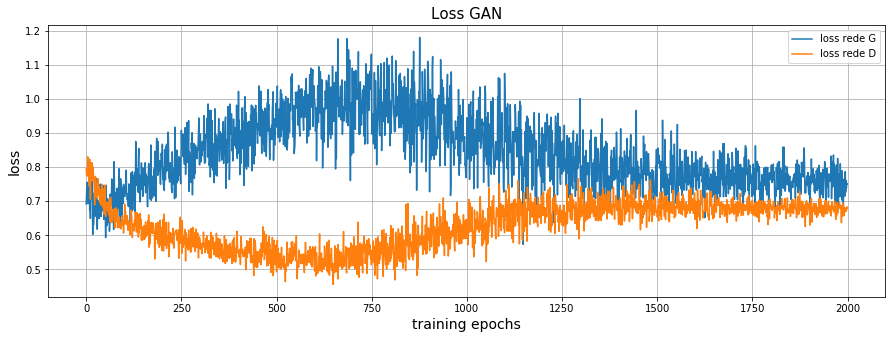

In [318]:
plt.figure(figsize=(15,5))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("training epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

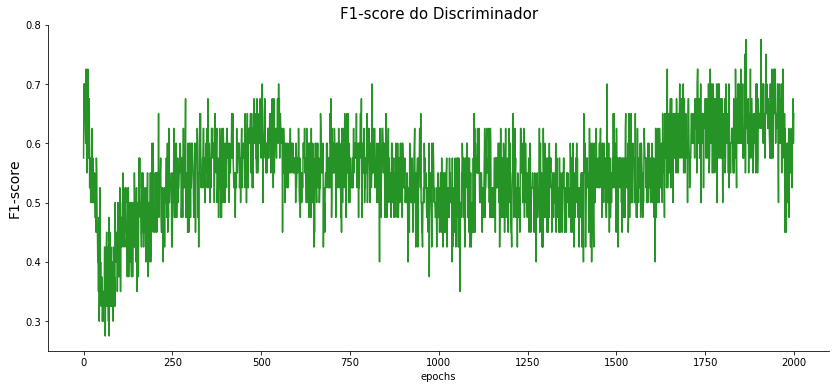

In [319]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("F1-score do Discriminador", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("F1-score", fontsize=14)
plt.plot(range(len(fscore)), fscore, color="green", alpha=.85);

(20, 2) (100, 2)


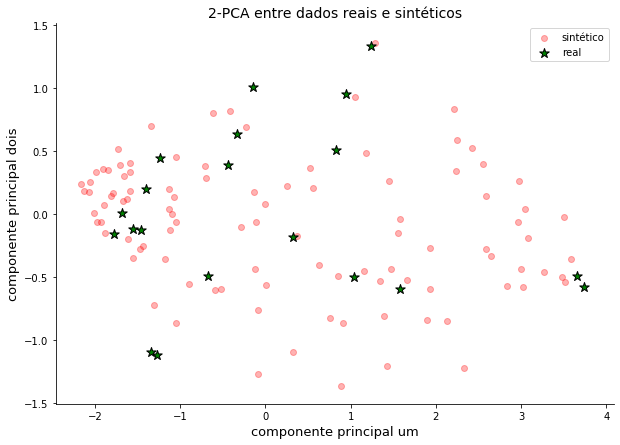

In [320]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(100, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [321]:
score = []
for i in range(5000):
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    score.append(np.mean((y_test - y_predict)**2))

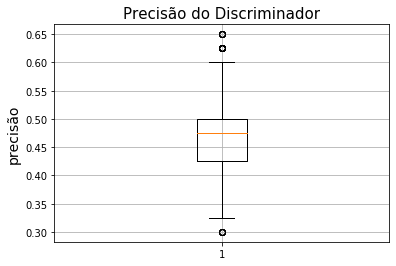

In [322]:
plt.title("Precisão do Discriminador", fontsize=15)
plt.ylabel("precisão", fontsize=14)
plt.grid("y")
plt.boxplot(score);

In [323]:
np.mean(score), np.std(score), np.median(score)

(0.471125, 0.05421355342531976, 0.475)

In [532]:
X_sint = G.predict(np.random.normal(0, 1, (60, noise_input)))
X_nov = np.concatenate((X_train.iloc[:10], X_sint))

In [619]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.138, gamma=.1).fit(X_train)

np.mean(clf.predict(X_train.iloc[:10]) == 1), np.mean(clf.predict(X_train.iloc[10:]) == 1)

(0.8, 1.0)

In [620]:
np.mean(clf.predict(X_nov)==1), np.mean(clf.predict(X_train)==1)

(0.7285714285714285, 0.9)

In [621]:
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964250,-1.031994,-0.934337,-0.939543,-0.937269
aaeB,-1.009480,-1.042995,-1.041304,-1.034891,-1.060889,-1.063096,-1.039629,-0.965042,-0.989310
aaeR,-1.006916,-0.996388,-1.082667,-0.987112,-1.078005,-1.014922,-1.058494,-0.940447,0.509951
aaeX,-0.943096,-0.955260,-0.950883,-0.910106,0.425601,-1.000392,-1.010278,-0.964826,0.441659
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996782,-0.974946,-0.973578,-0.897515,-0.892211


In [622]:
predict_cand = clf.predict(datos)

In [623]:
cand = datos[predict_cand == 1]
no_cand = datos[predict_cand == -1]
cand.shape

(748, 9)

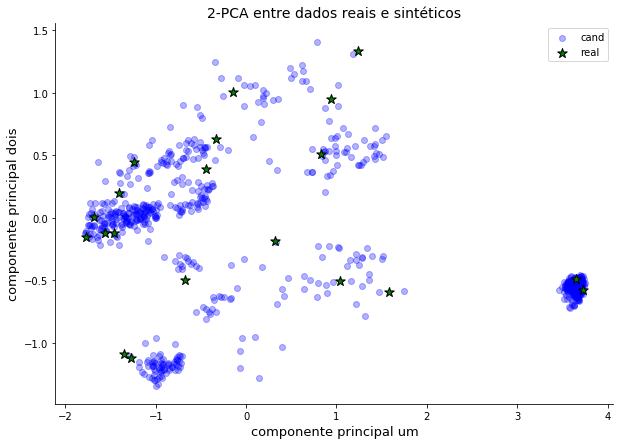

In [624]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand[:,0], X_cand[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="green", label="sintéticos",alpha=1, edgecolors="black")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [625]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [626]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242
thrW,-0.198341,-0.156393,-0.103735,-0.003529,-0.075905,-0.175493,-0.166364,1.018885,-0.263904
zupT,-0.722573,0.721750,0.753271,0.759741,0.757655,0.733104,0.654379,0.607526,0.687909


In [627]:
obj_edi = open("data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [628]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060
